In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import os
import matplotlib.pyplot as plt
data_name = 'MouseErythroid'

Global seed set to 0


In [2]:
# Where to get data from and where to save results (you need to modify this)
data_path = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/MouseErythroid/'
results_path = '/nfs/team283/aa16/cell2fate_paper_results/MouseErythroid/'

In [3]:
# Downloading data into specified directory:
os.system('cd ' + data_path + ' && wget -q https://cell2fate.cog.sanger.ac.uk/' + data_name + '/' + data_name + '_anndata.h5ad')

0

Load the data and extract most variable genes (and optionally remove some clusters).

In [4]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes= 3000)

Keeping at most 100000 cells per cluster
Filtered out 47456 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.


In [5]:
n_modules = c2f.utils.get_max_modules(adata)

Leiden clustering ...
Number of Leiden Clusters: 9
Maximal Number of Modules: 10


Overview of the dataset on a UMAP, coloured by cluster assingment.

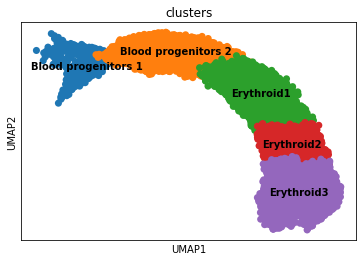

In [6]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')

As usual in the scvi-tools workflow we register the anndata object ...

In [7]:
c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced',
                                           batch_key = 'sequencing.batch')

... and initialize the model:

In [8]:
mod = c2f.Cell2fate_DynamicalModel(adata, n_modules = n_modules)

Let's have a look at the anndata setup:

In [9]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2fate_DynamicalModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sequencing.batch',
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced',
│   'cluster_label': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 9815  │
│      n_vars      │ 3000  │
│     n_batch      │   3   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                        batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sequencing.batch'] │     1      │          0          │
│                               │     2      │          1          │
│                               │     3      │          2          │
└───────────────────────────────┴────────────┴─────────────────────┘

Training the model:

In [10]:
mod.train(use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [17:39<00:00,  2.12s/it, v_num=1, elbo_train=3.27e+7]


We plot training history over multiple windows to effectively assess convergence (which is not reached here but it is close.)

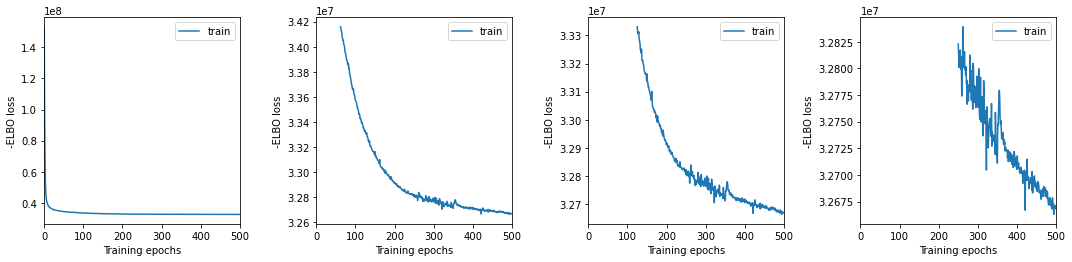

In [11]:
mod.view_history()

Here we export the model posterior to the anndata object:

In [12]:
adata = mod.export_posterior(adata)

sample_kwargs['batch_size'] 9815
Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:23<00:00,  1.23it/s]


One of the interesting parameter posteriors that was saved to the anndata object is the differentiation time:

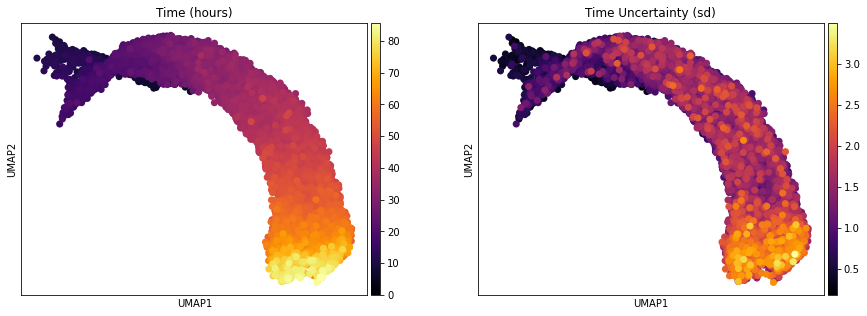

In [13]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1])
plt.savefig(results_path + data_name + 'UMAP_Time.pdf')

We can compute some module statistics to visualize the activity of the underlying modules:

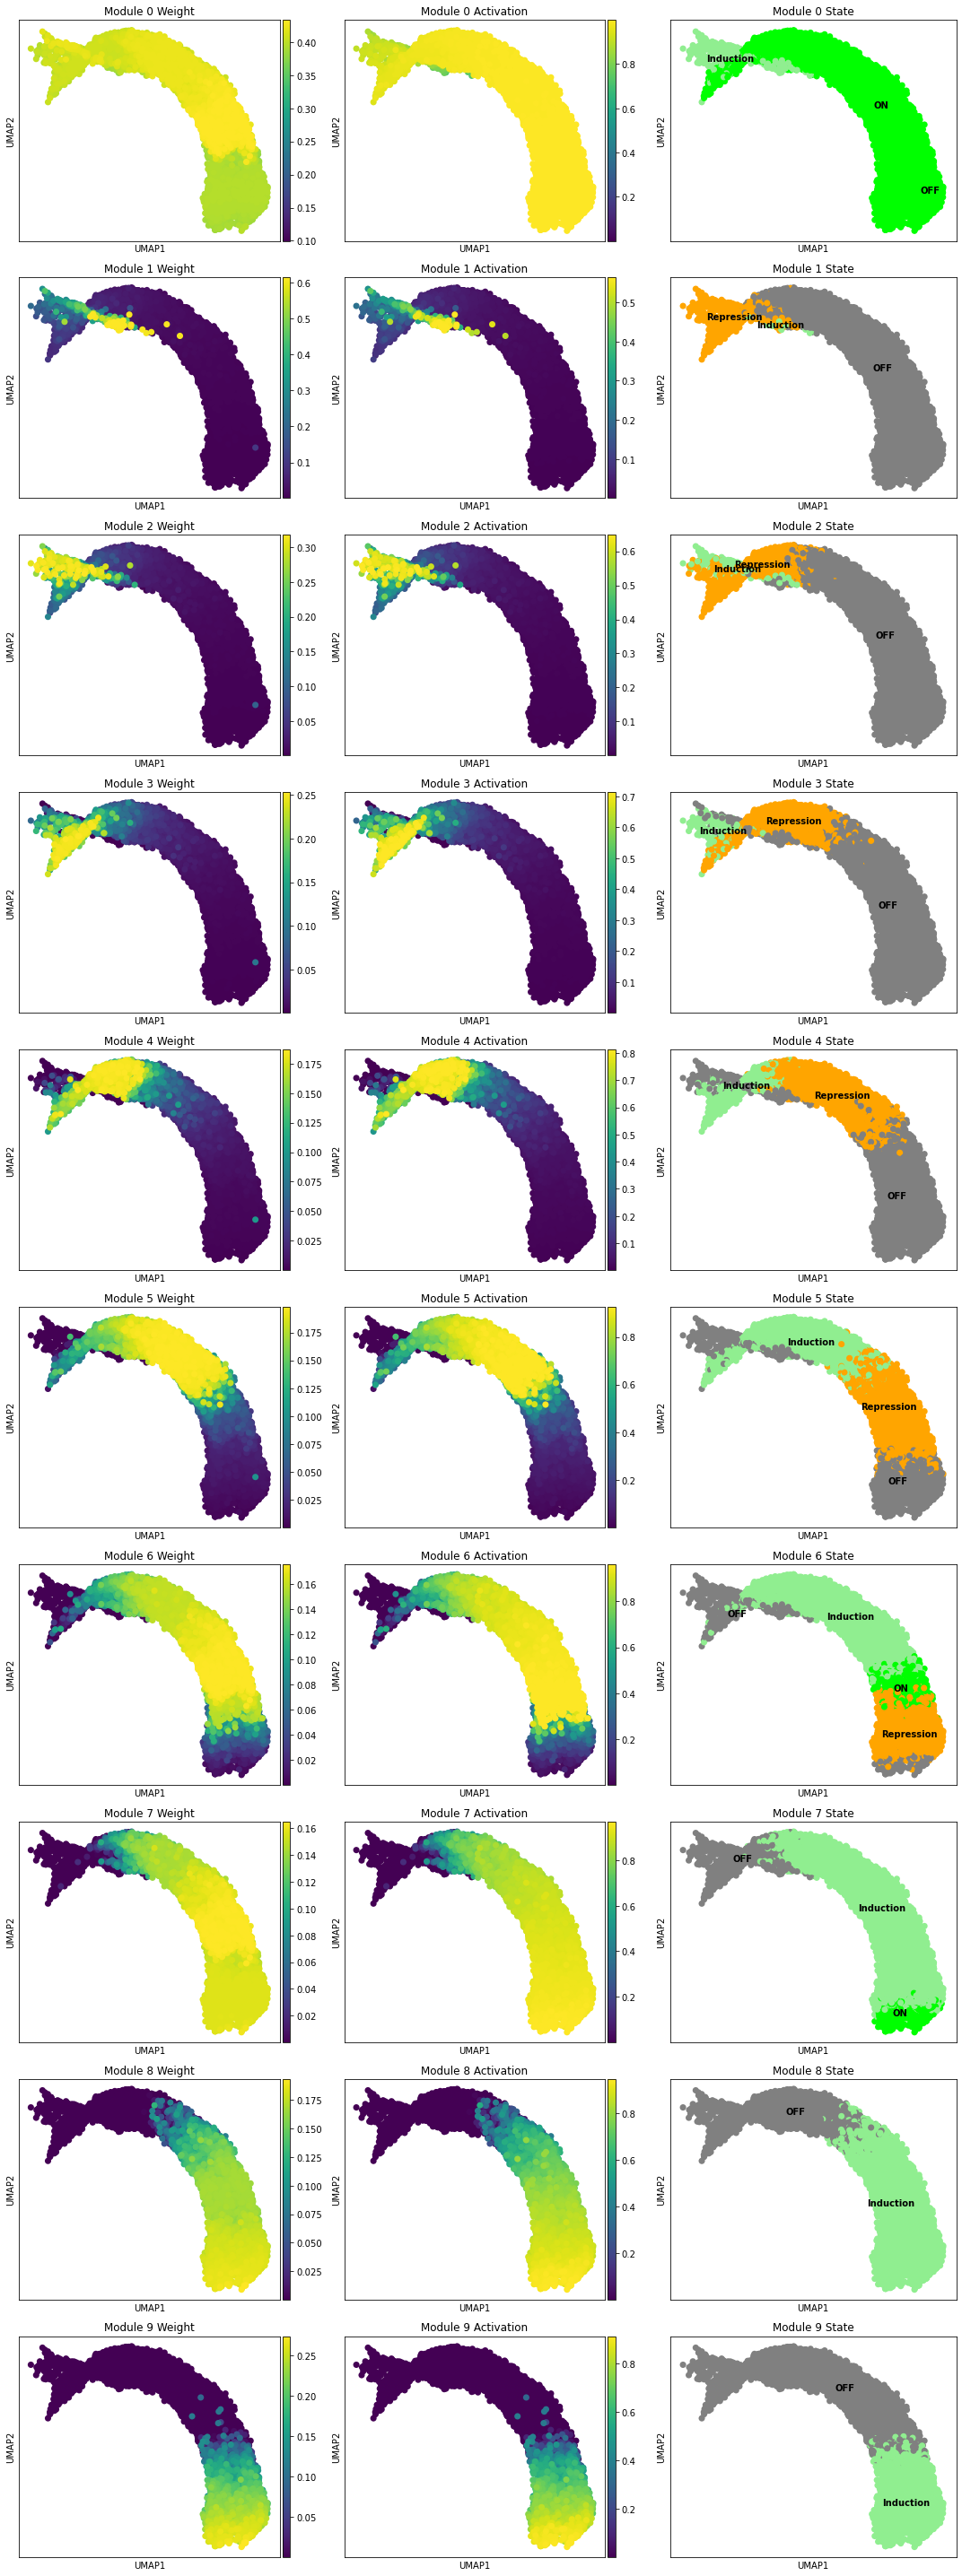

In [14]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata, save = results_path + data_name + 'module_summary_stats_plot.pdf')

In [15]:
# mod.compare_module_activation(adata, chosen_modules = [0,1,2,3,4,5],
#                          save = results_path + data_name + 'module_activation_comparison.pdf')

And of course we can make the usual visualization of total RNAvelocity on a UMAP:

Computing total RNAvelocity ...


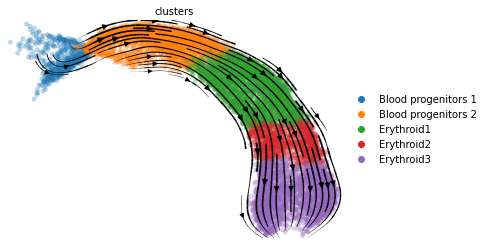

In [16]:
mod.compute_and_plot_total_velocity(adata, save = results_path + data_name + 'total_velocity_plots.png')

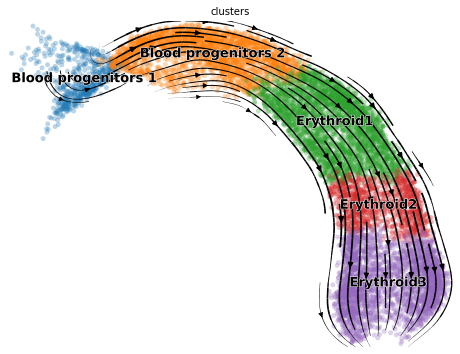

In [17]:
import matplotlib.pyplot as plt
import scvelo as scv
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='Velocity',
                                 show = False, ax = ax, legend_fontsize = 13)
plt.savefig(results_path + data_name + 'total_velocity_plots.png')

Technical variables usually show lower detection efficiency and higher noise (= lower overdispersion parameter) for unspliced counts:

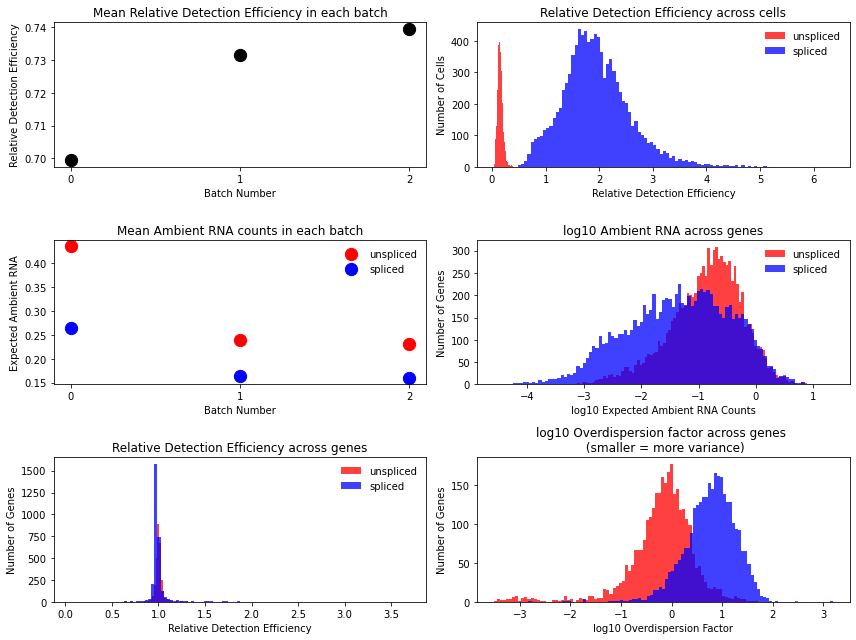

In [18]:
mod.plot_technical_variables(adata, save = results_path + data_name + 'technical_variables_overview_plot.pdf')

This is how to have a look at the various rate parameters the optimization converged to:

In [19]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

A_mgON mean: 0.057162873
gamma_g mean: 0.7793332
beta_g mean: 0.8615941
lam_mi, all modules: 
 
 [[[2.91 0.92]]

 [[3.99 3.96]]

 [[3.72 3.63]]

 [[4.28 4.47]]

 [[4.56 4.35]]

 [[4.42 4.07]]

 [[4.8  4.48]]

 [[4.8  2.28]]

 [[1.7  1.58]]

 [[2.37 1.54]]]


This method returns orders the genes and TFs in each module from most to least enriched. And it also performs gene set enrichment analysis:

In [20]:
tab, all_results = mod.get_module_top_features(adata, p_adj_cutoff=0.01, background = adata.var_names)
tab.to_csv(results_path + data_name + 'module_top_features_table.csv')

In [21]:
tab

,Module Number,Genes Ranked,TFs Ranked,Terms Ranked
0,0,"Cab39, Wee1, Zcchc8, Stt3a, Abi1, Phip, Tmem21...","Zcchc11, Atrx, Smarcad1, Kdm5c, Terf1, Sp3, Th...",proteasome-mediated ubiquitin-dependent protei...
1,1,"Med12l, Fcer1g, Angpt1, Gzmg, Fxyd5, Gimap6, C...","Meis1, Plek, Etv6, Mef2c, Pbx1, Zeb2, Foxn3, C...","platelet degranulation (GO:0002576), regulated..."
2,2,"Ptprg, Arhgap31, Fgd5, Zfp608, Sparc, Erg, Prk...","Zfp608, Erg, Elk3, Gli3, Tsc22d3, Junb, Ets2, ...",extracellular structure organization (GO:00430...
3,3,"Lgr5, Aplnr, Id3, H2afy2, Pde4dip, Gpc6, Car4,...","Id3, Klf5, Ebf1, Lef1, Smad6, Aff3, Mycn, Zfhx...",positive regulation of endothelial cell prolif...
4,4,"Rit1, Dpf2, Nrtn, Lama4, Myl9, Bcat2, Prpf38b,...","Dpf2, Emx2, Nfxl1, Gata2, Camta1, Dnmt3a, Myb,...",extracellular matrix organization (GO:0030198)...
5,5,"Gm15915, Sema6a, Endog, Abcg1, Il9r, Lsm3, Smi...","Dnajc21, Hmga1, Tgif2, Dr1, Ikzf2, Trp53, Esrr...",
6,6,"Emp3, Fpgs, Arl15, Qdpr, Focad, Hadh, Tnni1, A...","Ubtf, Zc3h8, Mbd6, Mta1, Zfp385a, Zfp62, Zfp77...",
7,7,"Dhx16, Zfp654, Vcpip1, Sord, Fam185a, Adck1, G...","Gmeb2, E2f2, Zc3h7a, Noc3l, Gata1, Mef2d, Zcch...",
8,8,"Car1, Nxpe2, Psd3, 2300009A05Rik, Rbp1, Fundc2...","Mllt3, Arid3a, Klf3, Cebpg, Zfp251, Runx1t1, Z...","heme biosynthetic process (GO:0006783), porphy..."
9,9,"Slc4a1, Ifi35, Trib3, Hebp1, Ipp, Vamp7, Kpna2...","Ttf1, Xbp1, Hbp1, Sfpq, Zscan21, Gfi1b, Arid3a...","heme biosynthetic process (GO:0006783), porphy..."


Plot transcription rate for MURK genes:

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
def mu_alpha(alpha_new, alpha_old, tau, lam):
    '''Calculates transcription rate as a function of new target transcription rate,
    old transcription rate at changepoint, time since change point and rate of exponential change process'''
    return (alpha_new - alpha_old) * (1 - torch.exp(-lam*tau)) + alpha_old

def mu_mRNA_continuousAlpha_withPlates(alpha, beta, gamma, tau, u0, s0, delta_alpha, lam):
    ''' Calculates expected value of spliced and unspliced counts as a function of rates, latent time, initial states,
    difference to transcription rate in previous state and rate of exponential change process between states.'''
    
    mu_u = u0*torch.exp(-beta*tau) + (alpha/beta)* (1 - torch.exp(-beta*tau)) + delta_alpha/(beta-lam+10**(-5))*(torch.exp(-beta*tau) - torch.exp(-lam*tau))
    mu_s = (s0*torch.exp(-gamma*tau) + 
    alpha/gamma * (1 - torch.exp(-gamma*tau)) +
    (alpha - beta * u0)/(gamma - beta+10**(-5)) * (torch.exp(-gamma*tau) - torch.exp(-beta*tau)) +
    (delta_alpha*beta)/((beta - lam+10**(-5))*(gamma - beta+10**(-5))) * (torch.exp(-beta*tau) - torch.exp(-gamma*tau))-
    (delta_alpha*beta)/((beta - lam+10**(-5))*(gamma - lam+10**(-5))) * (torch.exp(-lam*tau) - torch.exp(-gamma*tau)))

    return torch.stack([mu_u, mu_s], axis = -1)

def mu_mRNA_continousAlpha_globalTime_twoStates(alpha_ON, alpha_OFF, beta, gamma, lam_gi, T_c, T_gON, T_gOFF, Zeros):
    '''Calculates expected value of spliced and unspliced counts as a function of rates,
    global latent time, initial states and global switch times between two states'''
    n_cells = T_c.shape[-2]
    n_genes = alpha_ON.shape[-1]
    tau = torch.clip(T_c - T_gON, min = 10**(-5))
    t0 = T_gOFF - T_gON
    # Transcription rate in each cell for each gene:
    boolean = (tau < t0).reshape(n_cells, 1)
    alpha_cg = alpha_ON*boolean + alpha_OFF*~boolean
    # Time since changepoint for each cell and gene:
    tau_cg = tau*boolean + (tau - t0)*~boolean
    # Initial condition for each cell and gene:
    lam_g = ~boolean*lam_gi[:,1] + boolean*lam_gi[:,0]
    initial_state = mu_mRNA_continuousAlpha_withPlates(alpha_ON, beta, gamma, t0,
                                                       Zeros, Zeros, alpha_ON-alpha_OFF, lam_gi[:,0])
    initial_alpha = mu_alpha(alpha_ON, alpha_OFF, t0, lam_gi[:,0])
    u0_g = 10**(-5) + ~boolean*initial_state[:,:,0]
    s0_g = 10**(-5) + ~boolean*initial_state[:,:,1]
    delta_alpha = ~boolean*initial_alpha*(-1) + boolean*alpha_ON*(1)
    alpha_0 = alpha_OFF + ~boolean*initial_alpha
    # Unspliced and spliced count variance for each gene in each cell:
    mu_RNAvelocity = torch.clip(mu_mRNA_continuousAlpha_withPlates(alpha_cg, beta, gamma, tau_cg,
                                                         u0_g, s0_g, delta_alpha, lam_g), min = 10**(-5))
    alpha_0 = alpha_OFF + ~boolean*initial_alpha
    alpha_cg = mu_alpha(alpha_cg, alpha_0, tau_cg, lam_g)
    return mu_RNAvelocity, alpha_cg

In [23]:
n_cells = len(adata.obs_names)
n_vars = len(adata.var_names)

In [24]:
mu_m = []
alpha_cg = []

for m in range(n_modules):
    print(m)
    mu, alpha, = mu_mRNA_continousAlpha_globalTime_twoStates(
                torch.tensor(mod.samples['post_sample_means']['A_mgON'][m,:]),
                torch.tensor(0., dtype = torch.float),
                torch.tensor(mod.samples['post_sample_means']['beta_g']),
                torch.tensor(mod.samples['post_sample_means']['gamma_g']),
                torch.tensor(mod.samples['post_sample_means']['lam_mi'][m,...]),
                torch.tensor(mod.samples['post_sample_means']['T_c'][...,0]),
                torch.tensor(mod.samples['post_sample_means']['T_mON'][...,m]),
                torch.tensor(mod.samples['post_sample_means']['T_mOFF'][...,m]),
                torch.zeros((n_cells, n_vars)))
    mu_m += [m]
    alpha_cg += [alpha]
alpha = np.stack(alpha_cg, axis = 0)

0
1
2
3
4
5
6
7
8
9


In [25]:
MURK_genes = ['Hba-x', 'Smim1', 'Dcxr', 'Cox6b2', 'Gypa', 'Cpox', 'Hbb-bh1', 'Nudt4', 'Hbb-bt']

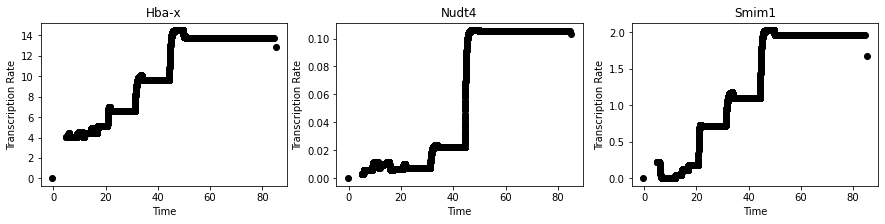

In [26]:
fig, ax = plt.subplots(1,3,figsize = (15, 3))
count = 0
for g in [0,7,1]:
    ax[count].scatter(mod.samples['post_sample_means']['T_c'][:,0,0], 
                np.sum(alpha_cg, axis = 0)[:, np.where(adata.var_names == MURK_genes[g])[0][0]],
               c = 'black')
    ax[count].set_title(MURK_genes[g])
    ax[count].set_xlabel('Time')
    ax[count].set_ylabel('Transcription Rate')
    count += 1
plt.savefig(results_path + data_name + 'MURK_geneTranscription_rate.pdf', bbox_inches="tight")